In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import imghdr
import os
import zarr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
import random
from pathlib import Path

In [2]:
# Placeholder function to determine class based on filename
def determine_class(filename):
    # A dictionary mapping substrings to their corresponding classes
    class_map = {
        "0862": "class_1",
        
        "0026": "class_2",
        "0089": "class_2",
        "0155": "class_2",
        '0339': "class_2",
        "0353": "class_2",
        "0817": "class_2",
        '1005': "class_2",
        "1044": "class_2",
        "1413": "class_2",
        
        "1636": "class_3",
        
        '1670': "class_4"
    }
    
    # Iterate through the dictionary to find a match
    for key, class_name in class_map.items():
        if key in filename:
            return class_name
    
    # Return a default value if no match is found
    return "unknown_class"

In [3]:
# Define the directory containing the Zarr files
def create_zarr_arrays(directory):
    # List to store each transposed Zarr array
    data_list = []
    # Counter to track the number of files processed
    file_count = 0
    max_files = 99999 

     # Iterate through each file in the directory
    for filename in os.listdir(directory):
        # Construct the full path to the file
        file_path = os.path.join(directory, filename)
        
        # Check if it's a directory (since Zarr files are typically stored in directories)
        if os.path.isdir(file_path):
            try:
                # Open the Zarr file
                print(f"Opening {file_path}")
                zarr_array = zarr.open(file_path, mode='r')
                
                # Transpose the Zarr array (channels, height, width)
                transposed_array = np.transpose(zarr_array, (2, 0, 1))
                
                # Determine the class of the image based on the filename
                image_class = determine_class(filename)
                
                # Store the data along with its metadata
                data_list.append({
                    'image_data': transposed_array,  # The actual image data
                    'class': image_class,            # The class determined
                    'filename': filename             # The original filename
                })
                # Increment the file count
                file_count += 1
                # Stop if the maximum number of files has been processed
                if file_count >= max_files:
                    break
                
            except Exception as e:
                # Handle cases where the file cannot be opened as a Zarr file
                print(f"Could not read {filename} as a Zarr file. Error: {e}")
    
    return data_list

In [4]:
# Function to generate subarea boundaries with emphasis towards the center
def generate_centered_boundaries(image_shape, subarea_size, subareas_per_image):
    channels, height, width = image_shape
    
    # Define the mean for the normal distribution (center of the image)
    mean_x = width // 2
    mean_y = height // 2
    
    # Define the standard deviation (smaller values will be more focused around the center)
    std_dev_x = width // 8  # Adjust these values to control how centered the selection is
    std_dev_y = height // 8

    boundaries = []

    for _ in range(subareas_per_image):
        # Sample coordinates using normal distribution centered at the image center
        top_left_x = int(np.clip(np.random.normal(loc=mean_x, scale=std_dev_x), 0, width - subarea_size[1]))
        top_left_y = int(np.clip(np.random.normal(loc=mean_y, scale=std_dev_y), 0, height - subarea_size[0]))
        
        # Store the boundaries
        boundaries.append((top_left_y, top_left_y + subarea_size[0], top_left_x, top_left_x + subarea_size[1]))
    
    return boundaries

# Function to extract a subarea given boundaries
def extract_subarea(image, boundaries):
    top_left_y, bottom_right_y, top_left_x, bottom_right_x = boundaries
    subarea = image[:, top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    return subarea


In [9]:
def generate_and_save_subareas(output_dir, data_list):
    # Create a directory for output if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through each item in data_list
    for data_item in data_list:
        # Extract the image data, class, and filename
        multi_channel_image = data_item['image_data']
        image_class = data_item['class']
        filename = data_item['filename']

        # Image size and subarea parameters
        image_shape = multi_channel_image.shape
        subarea_size = (2046, 2046)
        subareas_per_image = 100  # Number of subareas to extract

        # Generate centered boundaries
        boundaries_list = generate_centered_boundaries(image_shape, subarea_size, subareas_per_image)

        # Iterate over the generated boundaries and extract subareas
        for subarea_index, boundaries in enumerate(boundaries_list, start=1):
            subarea = extract_subarea(multi_channel_image, boundaries)

            # Define the subarea filename with the required format
            subarea_filename = f'{output_dir}/Subarea_{subarea_index}_for_{filename}_class_{image_class}.npy'
            np.save(subarea_filename, subarea)  # Saving as NumPy file for demonstration

            print(f"Saved subarea to: {subarea_filename}")


In [6]:
# Function to visualize the 16-channel image
def visualize_16_channel_image(image):
    channels, height, width = image.shape
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # 4x4 grid for 16 channels

    for i in range(channels):
        ax = axes[i // 4, i % 4]  # Determine position in the 4x4 grid
        ax.imshow(image[i], cmap='gray')  # Display each channel as a grayscale image
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
in_directory = r"C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs"
out_directory = r"C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output"
data_list = create_zarr_arrays(in_directory)

Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr01.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr02.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr03.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr04.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr05.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr06.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0026Cr07.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0089Cr01.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\ImportsFromGlobus\zarrs\PHerc0089Cr02.zarr
Opening C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Imp

In [10]:
# Takes up too mich space in disk, find a better way
#generate_and_save_subareas(out_directory, data_list)

Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_1_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_2_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_3_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_4_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_5_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_6_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_7_for_PHerc0026Cr01.zarr_class_class_2.npy
Saved subarea to: C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output/Subarea_8_for_PHerc

KeyboardInterrupt: 

Visualizing Subarea_100_for_PHerc0089Cr02.zarr_class_class_2.npy...


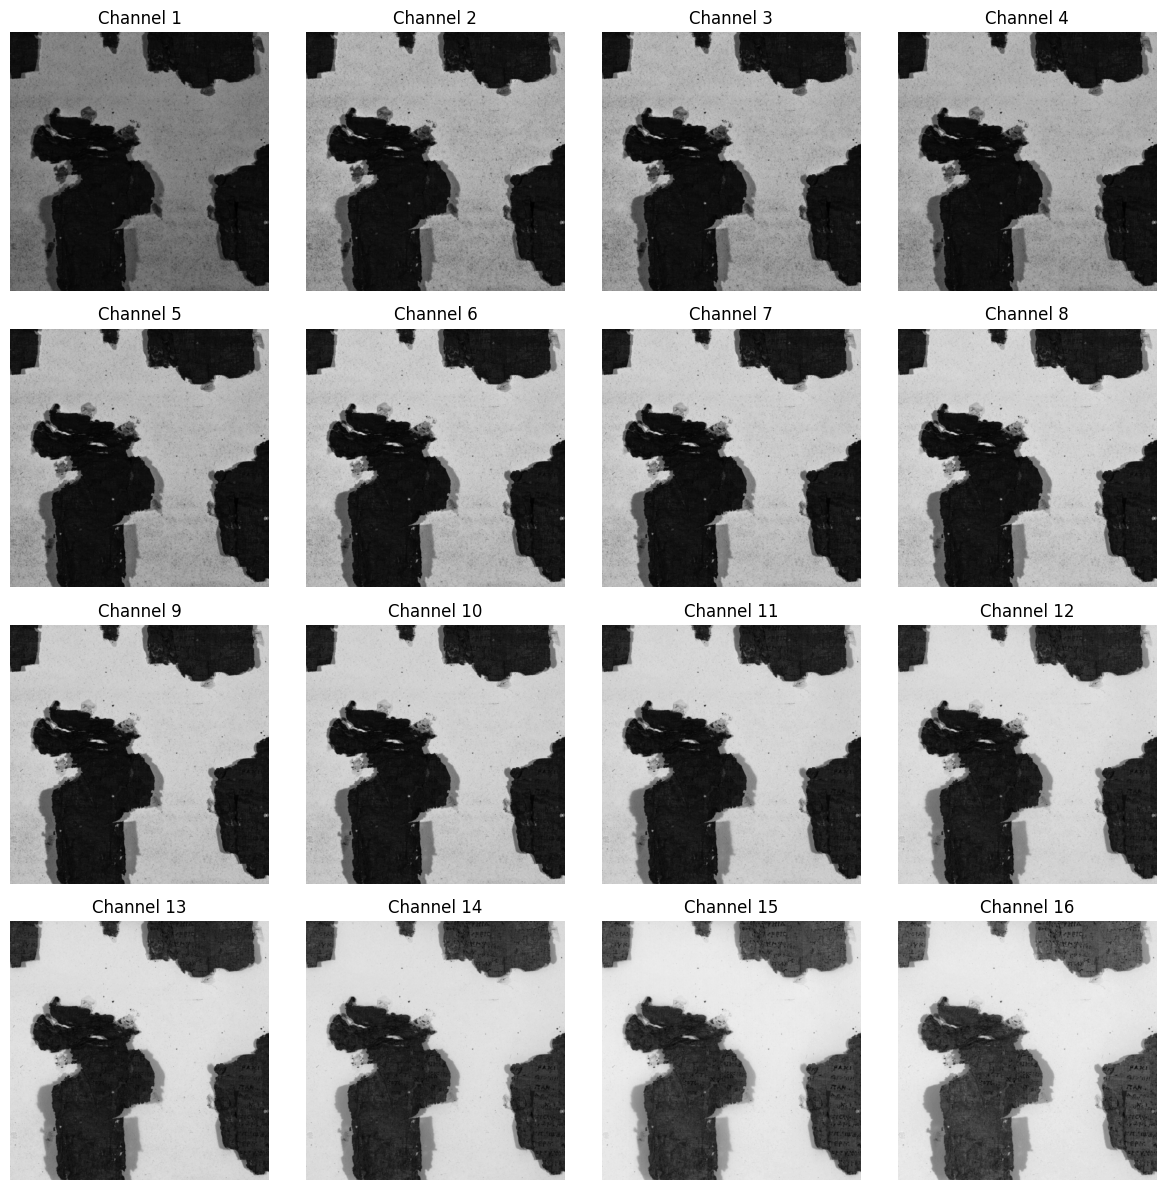

Visualizing Subarea_1_for_PHerc0089Cr03.zarr_class_class_2.npy...


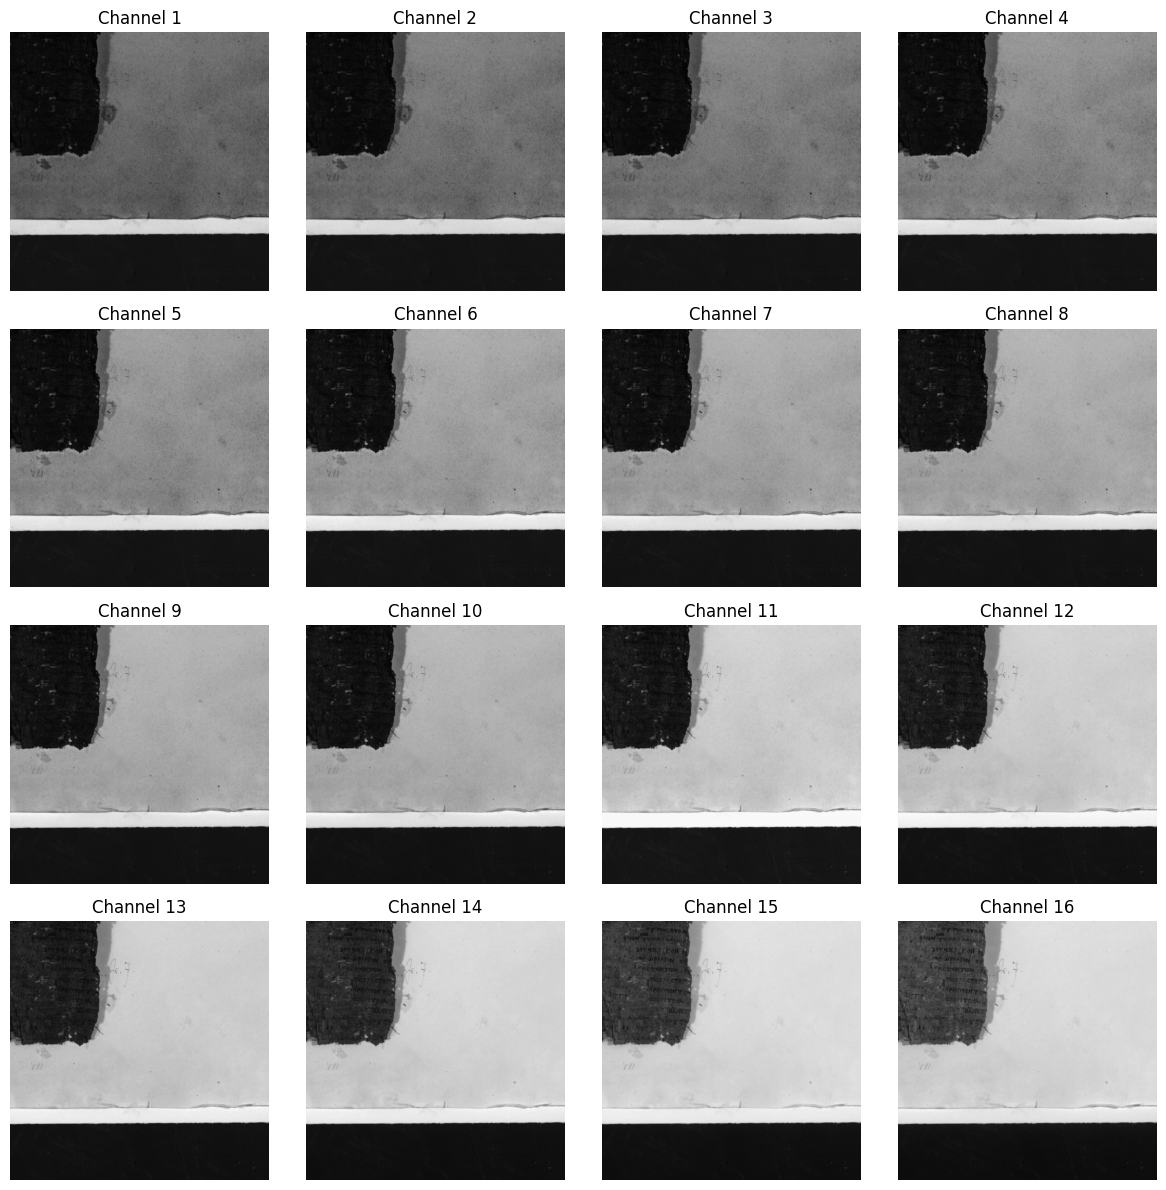

Visualizing Subarea_2_for_PHerc0089Cr03.zarr_class_class_2.npy...


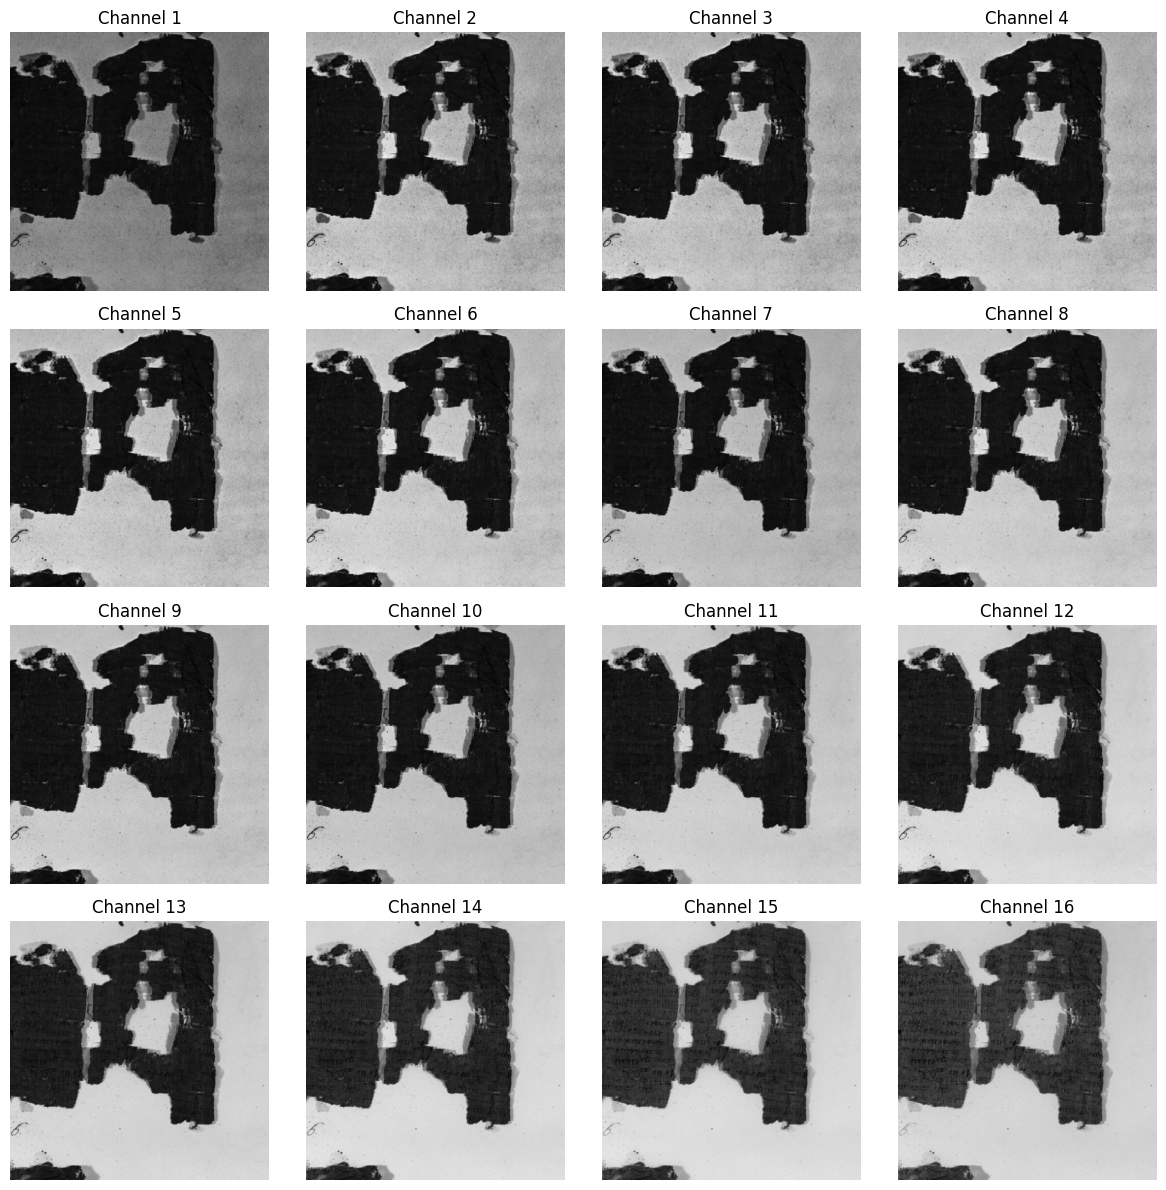

Visualizing Subarea_77_for_PHerc0089Cr02.zarr_class_class_2.npy...


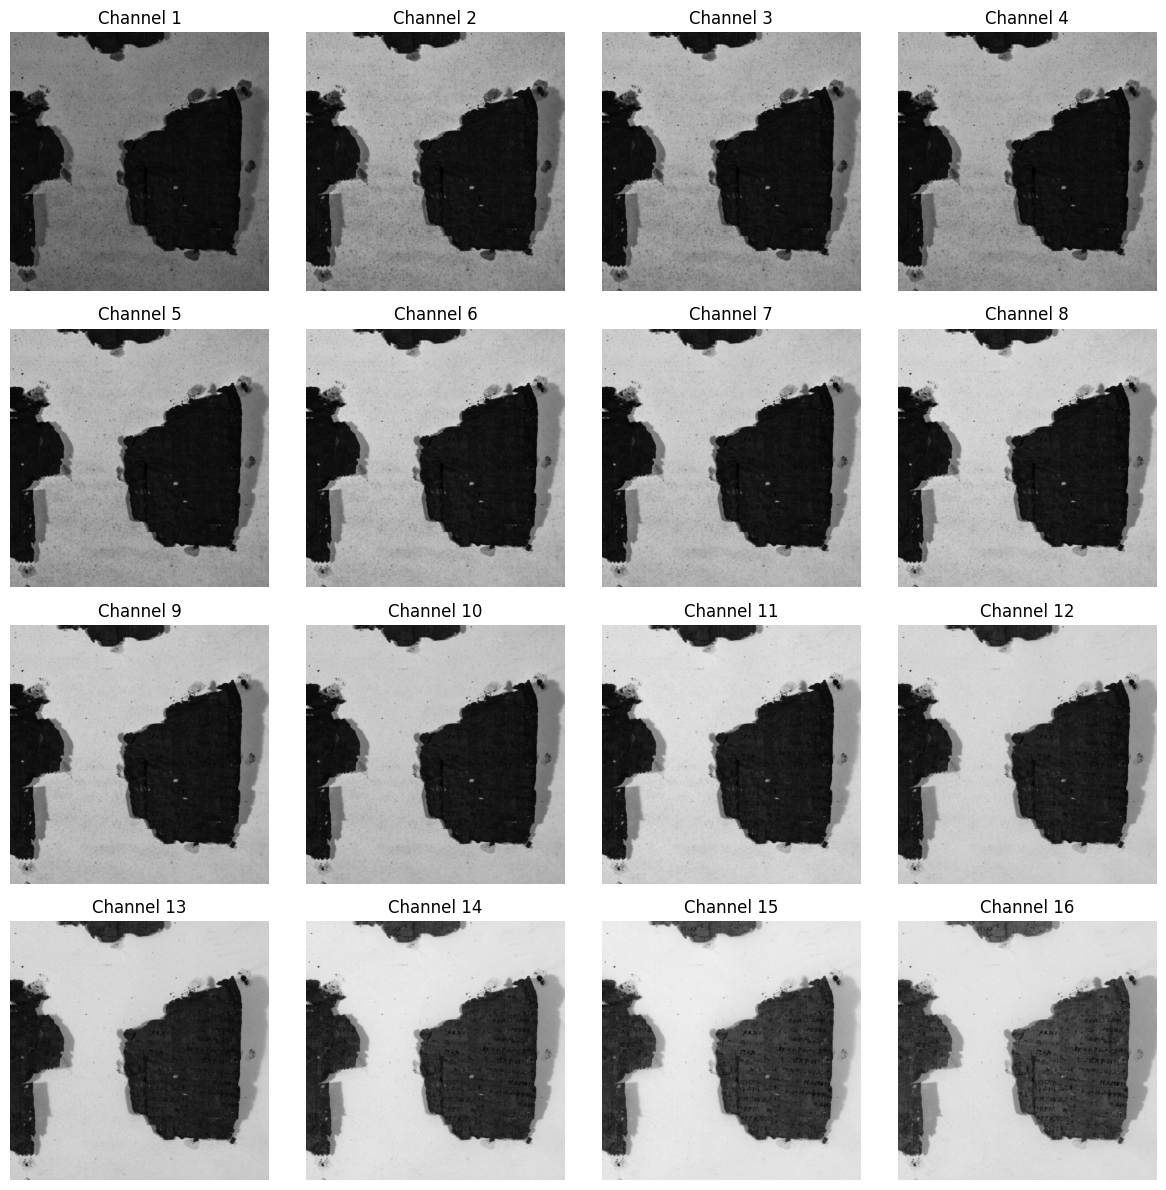

Visualizing Subarea_78_for_PHerc0089Cr02.zarr_class_class_2.npy...


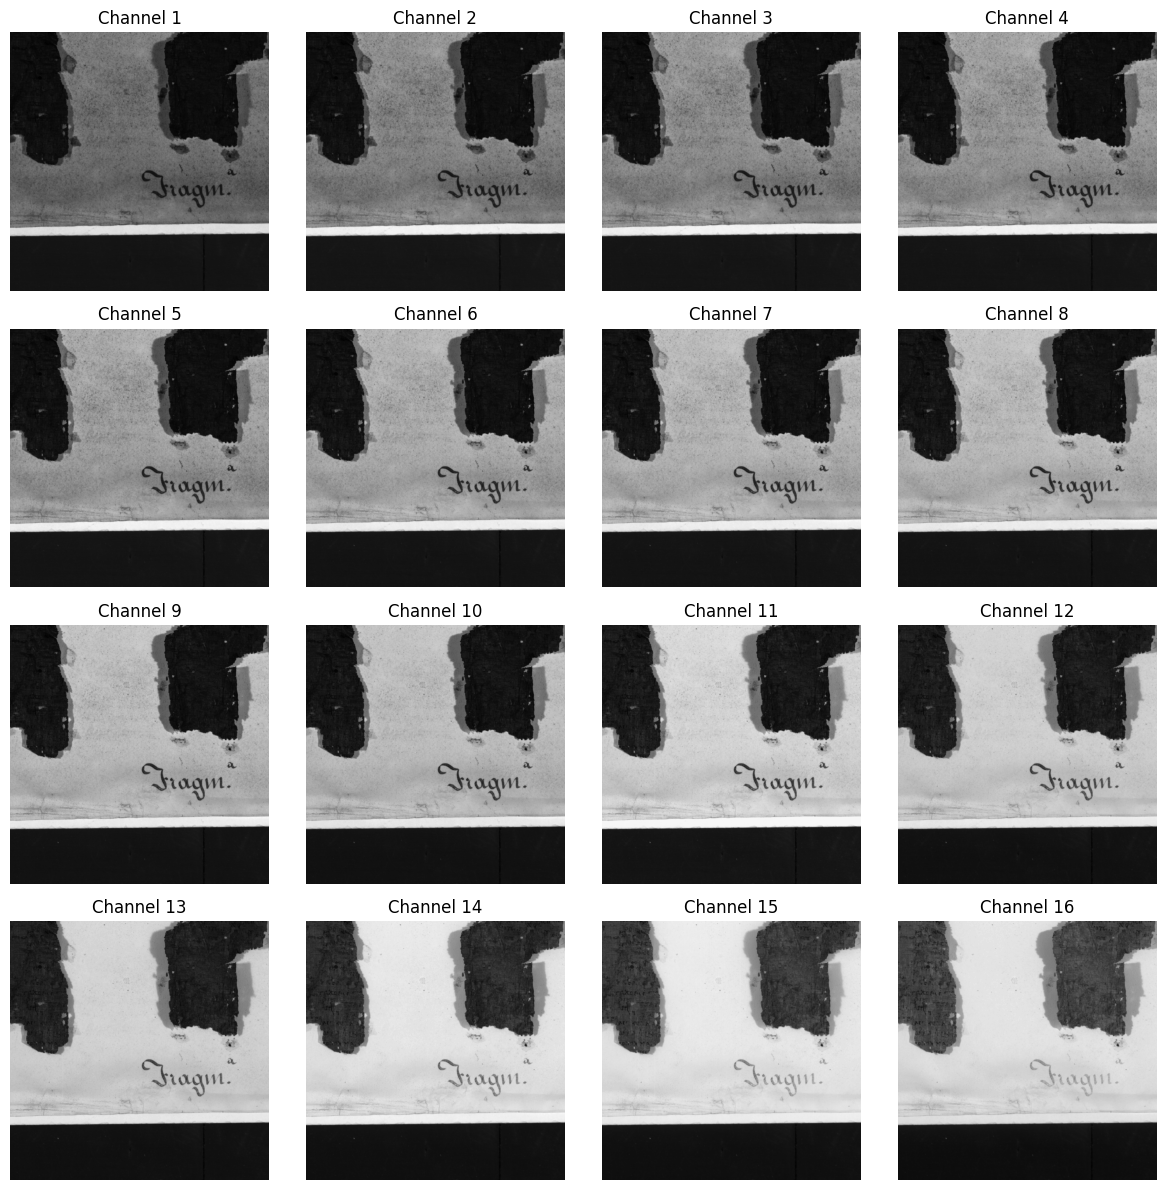

In [14]:
# Define the directory containing the output images
directory = r"C:\Users\Angel_Jose\EduceLab\HerculaneumAugmentation\Output"

counter = 0
max_img_displayed = 3
# Iterate over each image file in the directory
for image_file in os.listdir(directory):
    if image_file.endswith('.npy'):  # Ensure the file is a .npy file
        # Load the image data from the .npy file
        image_path = os.path.join(directory, image_file)
        image_data = np.load(image_path)
        
        # Visualize the 16-channel image
        print(f"Visualizing {image_file}...")
        visualize_16_channel_image(image_data)
        if counter > max_img_displayed:
            break
        counter += 1